In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path="/home/ubuntu/workspace/practice/code/Chapter_06/Bike-Sharing-Dataset/hour_noheader.csv"
raw_data=sc.textFile(path)
raw_data.first()

'1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16'

In [3]:
raw_data.count()

17379

In [4]:
records=raw_data.map(lambda x: x.split(","))
first=records.first()
print(first)
num_data=records.count()
print(num_data)

['1', '2011-01-01', '1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
17379


In [5]:
records.cache()

PythonRDD[6] at RDD at PythonRDD.scala:48

In [6]:
records.take(3)

[['1',
  '2011-01-01',
  '1',
  '0',
  '1',
  '0',
  '0',
  '6',
  '0',
  '1',
  '0.24',
  '0.2879',
  '0.81',
  '0',
  '3',
  '13',
  '16'],
 ['2',
  '2011-01-01',
  '1',
  '0',
  '1',
  '1',
  '0',
  '6',
  '0',
  '1',
  '0.22',
  '0.2727',
  '0.8',
  '0',
  '8',
  '32',
  '40'],
 ['3',
  '2011-01-01',
  '1',
  '0',
  '1',
  '2',
  '0',
  '6',
  '0',
  '1',
  '0.22',
  '0.2727',
  '0.8',
  '0',
  '5',
  '27',
  '32']]

In [7]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields:fields[idx]).distinct().zipWithIndex().collectAsMap()

In [8]:
mappings=[get_mapping(records, i) for i in range(2,10)]
print("Mapping of first cat features column: %s"%get_mapping(records, 2))

Mapping of first cat features column: {'4': 0, '1': 1, '3': 2, '2': 3}


In [9]:
for i in mappings:
    print(i)

{'4': 0, '1': 1, '3': 2, '2': 3}
{'0': 0, '1': 1}
{'10': 0, '4': 3, '5': 6, '3': 7, '2': 8, '7': 9, '1': 5, '12': 1, '8': 2, '9': 4, '11': 10, '6': 11}
{'10': 0, '18': 14, '17': 2, '5': 15, '13': 20, '7': 19, '0': 4, '14': 9, '22': 3, '16': 11, '11': 21, '19': 13, '15': 23, '12': 1, '3': 17, '2': 18, '1': 5, '6': 22, '4': 6, '23': 16, '9': 12, '21': 10, '20': 7, '8': 8}
{'0': 0, '1': 1}
{'4': 0, '1': 1, '5': 4, '3': 5, '2': 6, '0': 2, '6': 3}
{'0': 0, '1': 1}
{'4': 0, '1': 1, '3': 2, '2': 3}


#### 각 column(특징)별 카테코리의 수가 담겨 있음
#### range(2,10)이라고 정의하였으므로, fields[2] ~ fields[9]까지의 총 8개의 column을 대상으로 각각 카테고리의 수가 몇이나 되는지 계산할 수 있음

In [10]:
type(mappings[1])

dict

In [11]:
map(len, mappings[1])
#mappings 객체 자체는 list형이며, 내부 element가 모두 dict형인 객체이다.

In [12]:
records.first()[11:15]

['0.2879', '0.81', '0', '3']

4개의 실수변수는 그대로 사용할 예정,
각각 atemp, hum, windspeed, casual을 의미하는 듯 함

In [13]:
print(type(mappings))
print(list(map(len, mappings)))
print(sum(list(map(len,mappings))))

<class 'list'>
[4, 2, 12, 24, 2, 7, 2, 4]
57


In [14]:
mappings[1]
mappings[2]['10']
#mapping 참조시, list형이므로 괄호로 참조후, 내부 Dict에 맞추어 키값을 입력하면,
#해당 value값을 얻을 수 있음

0

In [15]:
cat_len = sum(list(map(len, mappings)))
num_len = len(records.first()[11:15])
total_len = num_len + cat_len

In [16]:
print("cat : %d, num : %d, total : %d"%(cat_len, num_len, total_len))

cat : 57, num : 4, total : 61


In [17]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [18]:
def extract_features(record):
    cat_vec=np.zeros(cat_len)
    i=0
    step=0
    for field in record[2:9]: #record가 아마 list형태로
        m=mappings[i] #column의 category 배열
        idx=m[field] #record를 키로하는 값을 idx에 대입
        cat_vec[idx+step]=1
        i=i+1
        step=step+len(m)
    
    num_vec=np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

def extract_label(record):
    return float(record[-1]) # -1은 마지막 변수를 의미

In [19]:
get_mapping(records, 2)

{'1': 1, '2': 3, '3': 2, '4': 0}

In [20]:
data=records.map(lambda r:LabeledPoint(extract_label(r), extract_features(r)))
first_point=data.first()
print("Raw data : "+str(first[2:]))
print("Label : "+str(first_point.label))
print("Linear Model feature vector:\n"+str(first_point.features))
print("Linear Model feature vector length : "+str(len(first_point.features)))

Raw data : ['1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Label : 16.0
Linear Model feature vector:
[0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length : 61


#### Linear 모델에서는 정보를 가공하여 바이너리 카테고리가 필요하지만, 의사결정모델은 주로 가공하지 않는 데이터를 처리한다.
카테고리 특징을 바이너리 벡터 인코딩으로 변환할 필요가 없음 => 카테고리 특징 직접 사용

In [21]:
def extract_features_dt(record):
    return np.array(list(map(float, record[2:14]))) #단순히 float 형으로 매핑한다
## 책 내용과는 다르게 list로 묶어주어야함. map이라는 함수 객체로 매핑됨(python 3.x)

data_dt = records.map(lambda r:LabeledPoint(extract_label(r), extract_features_dt(r)))

In [22]:
first_point_dt=data_dt.first()
print("Decision Tree feature vector: "+str(first_point_dt.features))
print("Decision Tree feature vector length : "+str(len(first_point_dt.features)))

Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length : 12


In [23]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
help(LinearRegressionWithSGD.train)

Help on method train in module pyspark.mllib.regression:

train(data, iterations=100, step=1.0, miniBatchFraction=1.0, initialWeights=None, regParam=0.0, regType=None, intercept=False, validateData=True, convergenceTol=0.001) method of builtins.type instance
    Train a linear regression model using Stochastic Gradient
    Descent (SGD). This solves the least squares regression
    formulation
    
        f(weights) = 1/(2n) ||A weights - y||^2
    
    which is the mean squared error. Here the data matrix has n rows,
    and the input RDD holds the set of rows of A, each with its
    corresponding right hand side label y.
    See also the documentation for the precise formulation.
    
    :param data:
      The training data, an RDD of LabeledPoint.
    :param iterations:
      The number of iterations.
      (default: 100)
    :param step:
      The step parameter used in SGD.
      (default: 1.0)
    :param miniBatchFraction:
      Fraction of data to be used for each SGD iteratio

In [24]:
from pyspark.mllib.linalg import SparseVector

a=SparseVector(1, {2:1.0, 3:5.5})

In [25]:
a.dot(a)

31.25

In [26]:
linear_model=LinearRegressionWithSGD.train(data, iterations=10, step=0.1)

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")
    에러 발생으로 인해, pyspark.ml.regression.LinearRegression을 대입 후 사용해 보기로

In [27]:
#from pyspark.ml.regression import LinearRegression
#linear_model=LinearRegression.fit(data, iterations=10, step=0.1, intercept=False)
#사용법이 다른듯함. train대신에 fit이라는 함수로 모델을 트레이닝 시킨다

In [28]:
true_vs_predicted=data.map(lambda p:(p.label, linear_model.predict(p.features)))

In [29]:
print("Linear Model predictions: "+str(true_vs_predicted.take(5)))

Linear Model predictions: [(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834317)]


In [30]:
type(true_vs_predicted.take(5))

list

In [31]:
dt_model=DecisionTree.trainRegressor(data_dt, {})

In [32]:
preds=dt_model.predict(data_dt.map(lambda p:p.features))
actual=data.map(lambda d:d.label)
true_vs_predicted_dt=actual.zip(preds)

In [33]:
print("Decision Tree predictions : "+str(true_vs_predicted_dt.take(5)))
print("Decision Tree depth : "+str(dt_model.depth()))
print("Decision Tree number of nodes: "+str(dt_model.numNodes()))

Decision Tree predictions : [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth : 5
Decision Tree number of nodes: 63


In [34]:
def squared_error(actual, pred):
    return (pred - actual)**2

def abs_error(actual, pred):
    return np.abs(pred - actual)

def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [35]:
mse = true_vs_predicted.map(lambda t: squared_error(t[0], t[1])).mean()
mae = true_vs_predicted.map(lambda t: abs_error(t[0], t[1])).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda t: squared_log_error(t[0], t[1])).mean())
print("Linear Model - Mean Squared Error: %2.4f" % mse)
print("Linear Model - Mean Absolute Error: %2.4f" % mae)
print("Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle)

Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absolute Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653


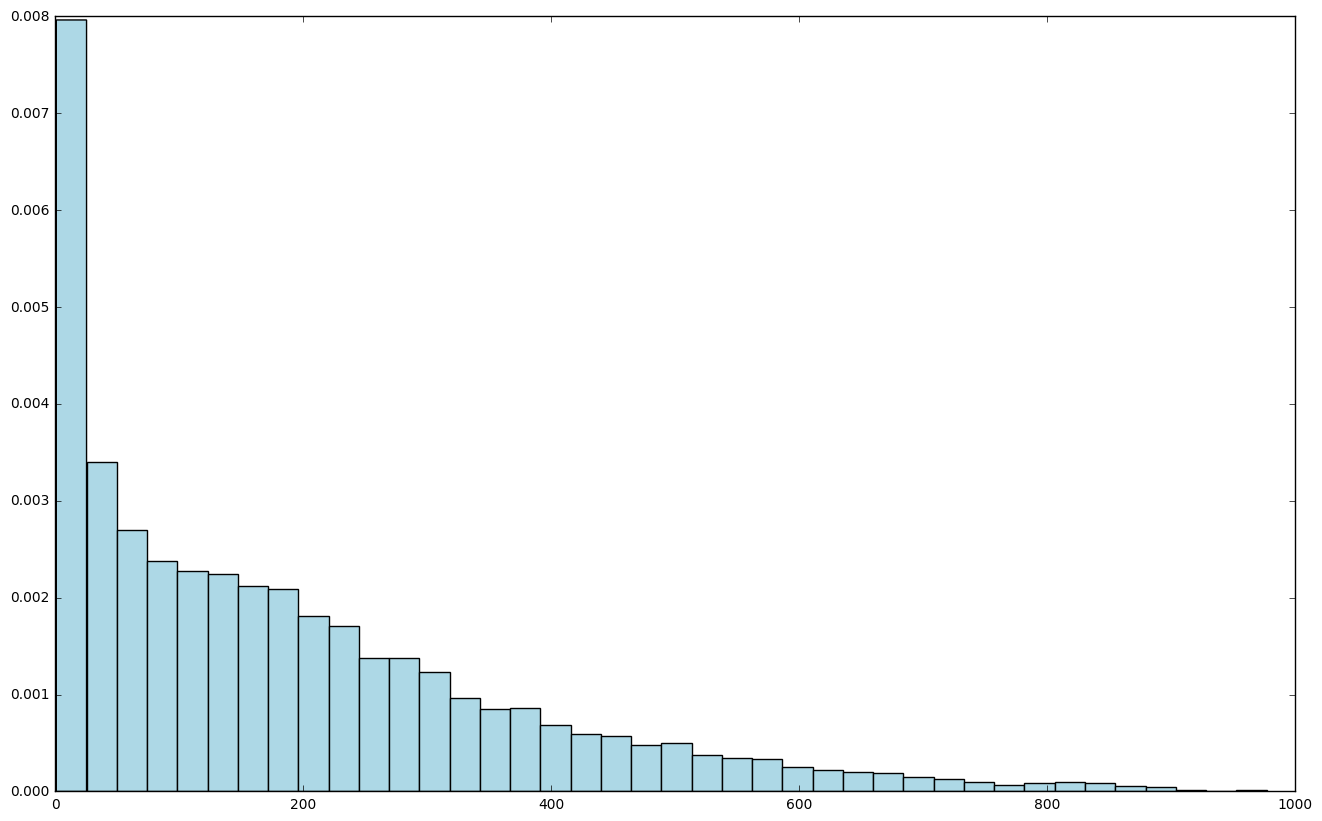

In [36]:
targets=records.map(lambda r:float(r[-1])).collect()
hist(targets, bins=40, color='lightblue', normed=True)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

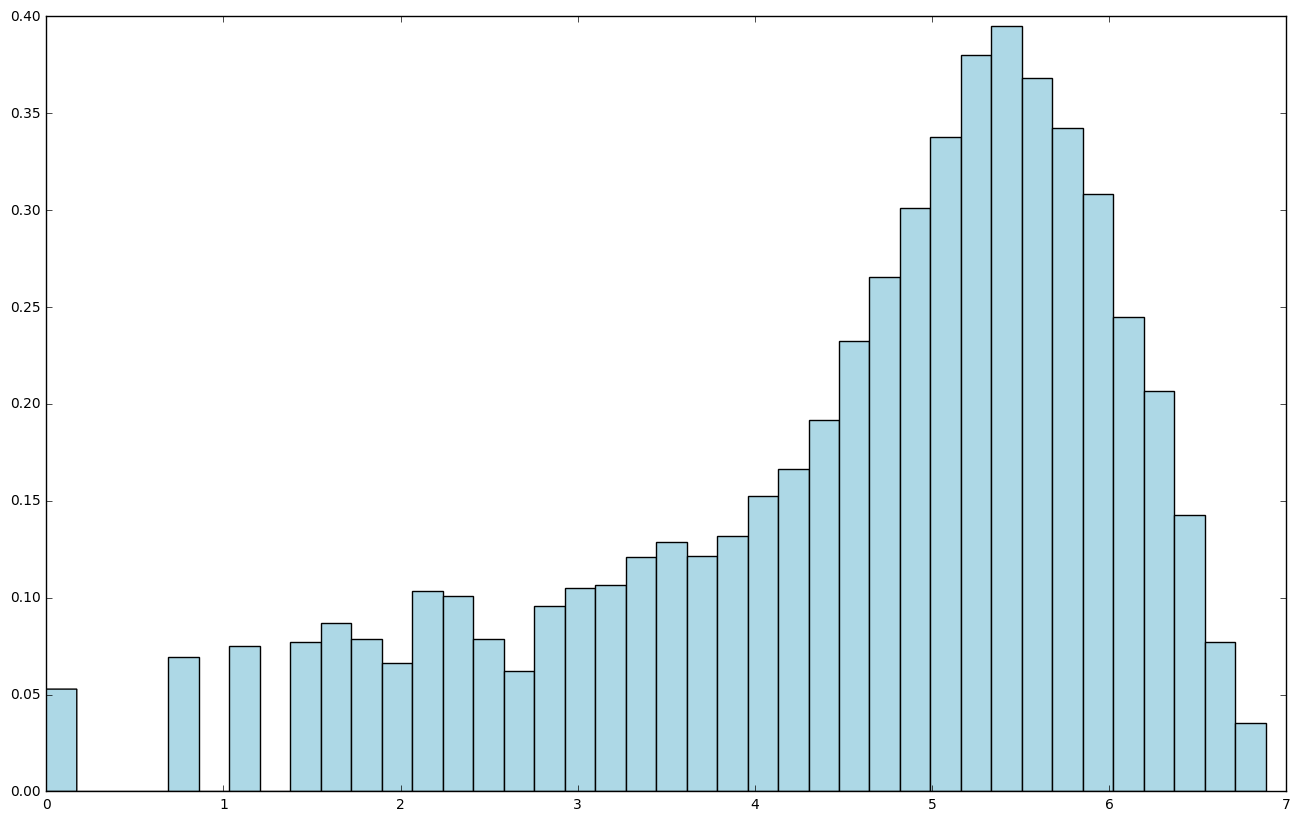

In [37]:
log_targets=records.map(lambda r:np.log(float(r[-1]))).collect() # 타켓변수의 로그화
hist(log_targets, bins=40, color='lightblue', normed=True) #타켓변수 = 원래의 값(y)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

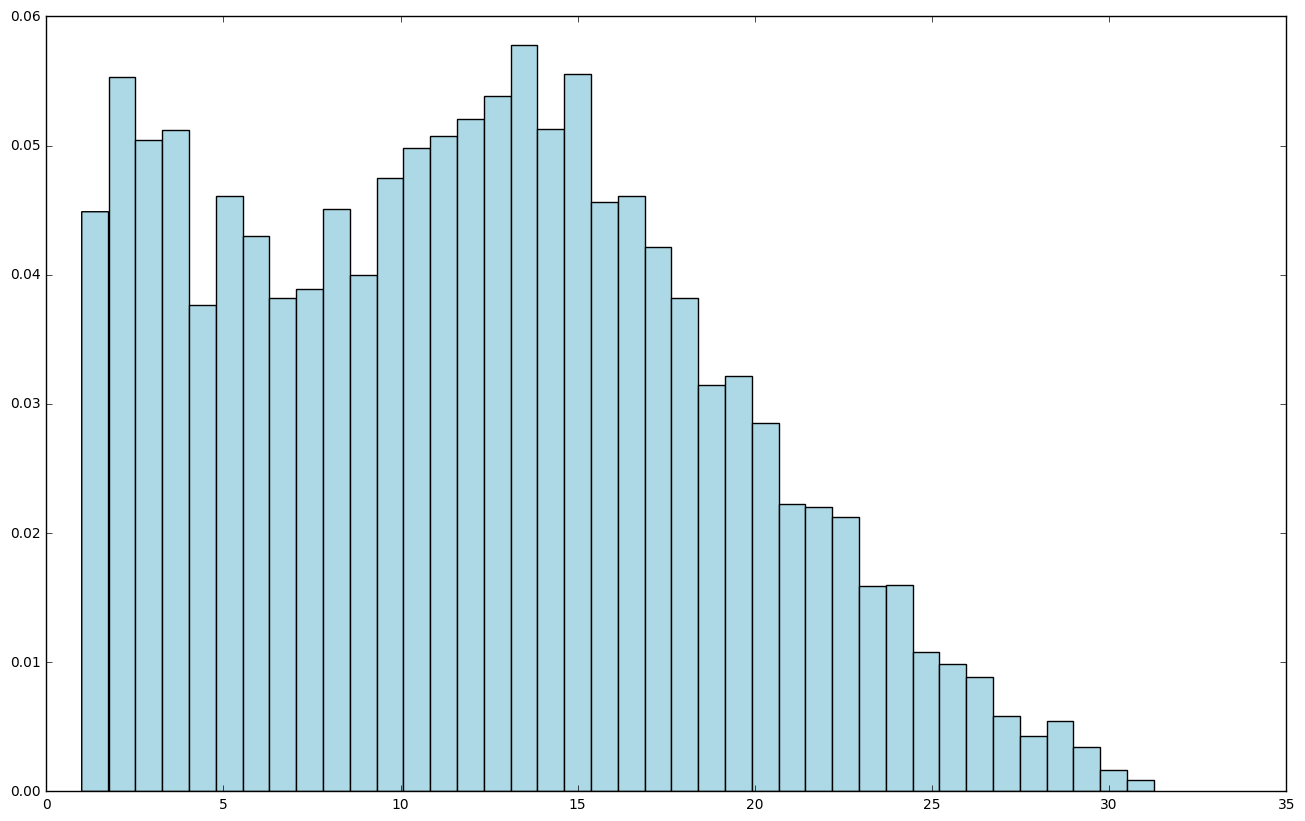

In [38]:
sqrt_targets=records.map(lambda r:np.sqrt(float(r[-1]))).collect()
hist(sqrt_targets, bins=40, color='lightblue', normed=True)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

In [39]:
data_log=data.map(lambda lp:LabeledPoint(np.log(lp.label), lp.features))
model_log=LinearRegressionWithSGD.train(data_log,iterations=10, step=0.1)

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


In [40]:
true_vs_predicted_log=data_log.map(lambda d:(np.exp(d.label), np.exp(model_log.predict(d.features))))

In [41]:
mse_log=true_vs_predicted_log.map(lambda t:squared_error(t[0], t[1])).mean()
mae_log=true_vs_predicted_log.map(lambda t:abs_error(t[0], t[1])).mean()
rmsle_log=true_vs_predicted_log.map(lambda t:squared_log_error(t[0], t[1])).mean()

In [42]:
print("Mean Squared Error: %2.4f"%mse_log)
print("Mean Absolute Error: %2.4f"%mae_log)
print("Root Mean Squared Log Errror: %2.4f"%rmsle_log)
print("Non log-transformed predictions:\n"+str(true_vs_predicted.take(3)))
print("Log-transformed predictions:\n"+str(true_vs_predicted_log.take(3)))

Mean Squared Error: 50685.5559
Mean Absolute Error: 155.2955
Root Mean Squared Log Errror: 2.3749
Non log-transformed predictions:
[(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456212), (40.0, 26.959480191001784), (32.0, 26.654725629458021)]


In [45]:
data_dt_log=data_dt.map(lambda d:LabeledPoint(np.log(d.label), d.features))
dt_model_log=DecisionTree.trainRegressor(data_dt_log, {})
preds_log=dt_model_log.predict(data_dt_log.map(lambda r:r.features))
actual_log=data_dt_log.map(lambda p:p.label)

true_vs_predicted_dt_log=actual_log.zip(preds_log).map(lambda t:(np.exp(t[0]), np.exp(t[1])))

mse_log_dt=true_vs_predicted_dt_log.map(lambda p:squared_error(p[0], p[1])).mean()
mae_log_dt=true_vs_predicted_dt_log.map(lambda p:abs_error(p[0], p[1])).mean()
rmsle_log_dt=true_vs_predicted_dt_log.map(lambda p:squared_log_error(p[0], p[1])).mean()

print("Mean Squared Error: %2.4f"%mse_log_dt)
print("Mean Absolute Error: %2.f"%mae_log_dt)
print("Root Mean Squared Log Error: %2.4f"%rmsle_log_dt)
print("Non log-transformed predictions:\n"+str(true_vs_predicted_dt.take(3)))
print("Log-transformed predictions:\n"+str(true_vs_predicted_dt_log.take(3)))

Mean Squared Error: 14781.5760
Mean Absolute Error: 76
Root Mean Squared Log Error: 0.4104
Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Log-transformed predictions:
[(15.999999999999998, 37.530779787154508), (40.0, 37.530779787154508), (32.0, 7.2797070993907287)]


In [46]:
data_with_idx=data.zipWithIndex().map(lambda t:(t[1], t[0]))
test=data_with_idx.sample(False, 0.2, 42)
train=data_with_idx.subtractByKey(test)

In [47]:
train_data=train.map(lambda p:p[1]) #lambda(idx,p):p
test_data=test.map(lambda t:t[1])
train_size=train_data.count()
test_size=test_data.count()
print("Training data size : %d"%train_size)
print("Test data size : %d"%test_size)
print("Total data size : %d"%num_data)
print("Train + test size : %d"%(train_size+test_size)) #제대로 분리되었는지 확인

Training data size : 13869
Test data size : 3510
Total data size : 17379
Train + test size : 17379


In [48]:
data_with_idx_dt=data_dt.zipWithIndex().map(lambda t:(t[1], t[0]))
test_dt=data_with_idx_dt.sample(False, 0.2, 42)
train_dt=data_with_idx_dt.subtractByKey(test_dt)
train_data_dt=train_dt.map(lambda p:p[1])
test_data_dt=test_dt.map(lambda p:p[1])

In [49]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model=LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp=test.map(lambda p:(p.label, model.predict(p.features)))
    rmsle=np.sqrt(tp.map(lambda t:squared_log_error(t[0], t[1])).mean())
    return rmsle

In [50]:
#params라는 변수를 만들어 반복에 대해 테스트를 한다
#반복을 많이 하게 되면 과연 오차값은 계속 줄어들까?
params=[1, 5, 10, 20, 50, 100, 200, 500, 1000]
metrics=[evaluate(train_data, test_data, param, 0.01, 0.0, 'l2', False) for param in params]
print(params)
print(metrics)

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[1, 5, 10, 20, 50, 100, 200, 500, 1000]
[2.8895751840351522, 2.0389907666484954, 1.7689106650446305, 1.5672874678333344, 1.4112887844157063, 1.3708564590941774, 1.3796853319834623, 1.3973866554007046, 1.3973866554007046]


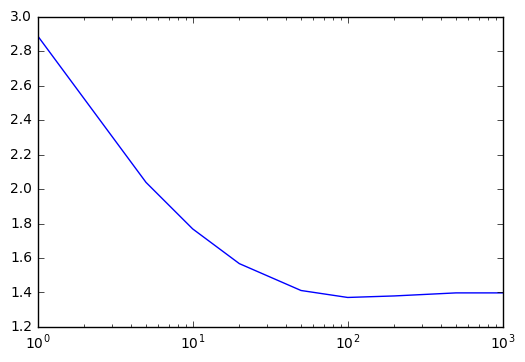

In [51]:
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
pyplot.xscale('log')
#책 내용과는 다르게 일단은 일정 수치 이상일때, 더 이상 효과 가없는 것으로 확인 되었다.

In [52]:
#반복 단위 크기(α)
params=[0.01, 0.025, 0.05, 0.1, 1.0]
metrics=[evaluate(train_data, test_data, 10, param, 0.0, 'l2', False) for param in params]
print(params)
print(metrics)

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.01, 0.025, 0.05, 0.1, 1.0]
[1.7689106650446305, 1.4109119656546196, 1.3796577774333101, 1.4580779096997893, nan]


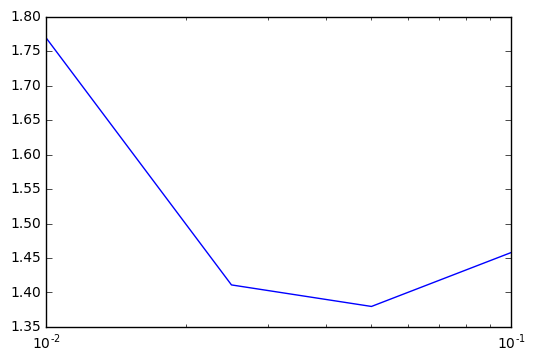

In [53]:
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
pyplot.xscale('log')

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.4580779096997893, 1.4574329945186553, 1.4517403325137033, 1.4055537710502841, 1.3809678070431126, 1.5198891882336292, 1.8224536571417234]


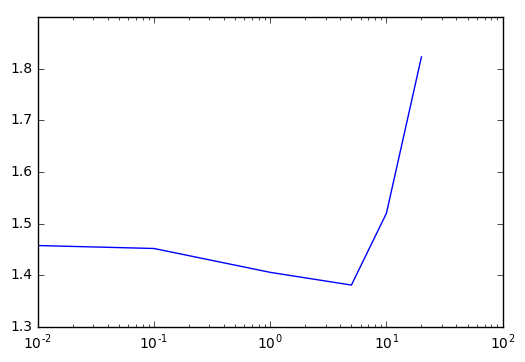

In [54]:
#Regparam : 규칙화에 따른 정도 변수
#L2(ridge) Regression
params=[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
metrics=[evaluate(train_data, test_data, 10, 0.1, param, 'l2',False) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf() #여기 빠져도 큰 오류가 나거나 그런건 없음
pyplot.xscale('log')

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.4580779096997893, 1.458043054492044, 1.4577312609446176, 1.4548207151817401, 1.4279738870738146, 1.7425548127469279, 4.7750969001089763]


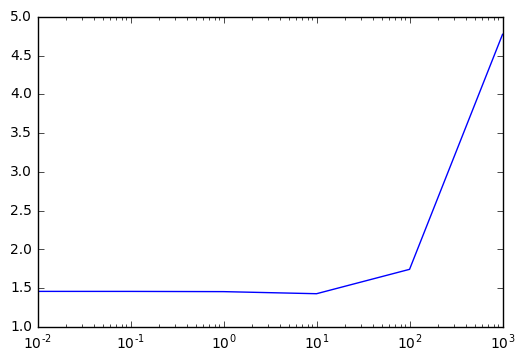

In [55]:
#L1 Regression(lasso Regression)
params=[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics=[evaluate(train_data, test_data, 10, 0.1, param, 'l1', False) for param in params]
print(params)
print(metrics)
plot(params, metrics)
pyplot.xscale('log')
#l2 보다 상대적으로 필요한 레벨은 매우 높으나, 전체적인 성능이 낮음

In [56]:
#L1 regression는 가중치 벡터가 산발적으로 나타내게 할 수 있음
model_l1=LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=1.0, regType="l1", intercept=False)
model_l1_10=LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=10.0, regType="l1", intercept=False)
model_l1_100=LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=100.0, regType="l1", intercept=False)

/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


In [57]:
model_l1.weights #DenseVector형으로 취합된다.

DenseVector([12.5264, 2.8526, 16.678, 13.5464, 12.9166, 33.6909, 4.8844, 1.6966, 5.1464, 3.3036, 5.2882, 0.0, 4.6513, 2.3896, 0.5997, 5.1272, 3.1667, 5.337, 1.1434, 2.8492, 7.0395, 0.2338, -0.6832, -0.9395, -1.4157, 2.263, 5.0843, 2.5945, 1.0761, 4.0328, 2.1356, 4.245, 6.5272, -1.2001, -0.2689, -1.305, -1.1792, 1.9665, 2.9048, 1.8767, -0.3811, 2.6791, 45.6855, 0.9221, 6.5515, 6.0761, 6.0488, 6.8306, 6.5193, 6.0418, 6.0289, 14.8058, 31.8018, 0.0, 0.0, 0.0, 0.0, 29.5086, 27.7728, 23.505, 9.5965])

In [58]:
model_l1.weights.array #array형태로 변환되며 %.8f 형태인 것을 확인할 수 있다.

array([ 12.52640459,   2.85261546,  16.67797341,  13.54639589,
        12.91664524,  33.69094369,   4.88438113,   1.69664439,
         5.14643714,   3.30361912,   5.28817493,   0.        ,
         4.65127878,   2.38959239,   0.59973903,   5.12716367,
         3.1666576 ,   5.33704646,   1.14340028,   2.84923583,
         7.03947112,   0.23376493,  -0.68315258,  -0.93952126,
        -1.41574352,   2.26295339,   5.0843379 ,   2.59453162,
         1.07607773,   4.03277571,   2.13556129,   4.24498267,
         6.52719223,  -1.20011114,  -0.26892104,  -1.30495111,
        -1.1792426 ,   1.96651028,   2.9048412 ,   1.8766549 ,
        -0.38107755,   2.67910007,  45.68551238,   0.92207656,
         6.55147783,   6.07608263,   6.04884497,   6.83064333,
         6.51931711,   6.04178092,   6.02894319,  14.80576444,
        31.80182449,   0.        ,   0.        ,   0.        ,
         0.        ,  29.50862225,  27.77281912,  23.50499259,   9.59654316])

In [59]:
(model_l1.weights.array==0) #모든 인자가 False/True 형태로 변하게 된다.

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True, False, False, False, False], dtype=bool)

In [60]:
model_l1.weights.array==0 # 일치하는 수만 취합하여 몇개인지 확인할 수 있음
#array형이 아닐시에는 인자형태로 처리하지 않기때문에 정확한 값을 얻을 수 없음

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True, False, False, False, False], dtype=bool)

In [61]:
print("L1 zero weights : "+str(sum(model_l1.weights.array==0)))
print("L1(10) zero weights : "+str(sum(model_l1_10.weights.array==0)))
print("L1(100) zero weights : "+str(sum(model_l1_100.weights.array==0)))
#L1 Regression은 변화가 큰 가중치 벡터를 제외한 나머지 벡터를 소거한다.
#또한 규칙화 레벨이 증가할 수록, W=0인 인자가 늘어난다.

L1 zero weights : 5
L1(10) zero weights : 33
L1(100) zero weights : 58


/usr/local/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[True, False]
[1.4363265851099394, 1.4055537710502841]


<Container object of 2 artists>

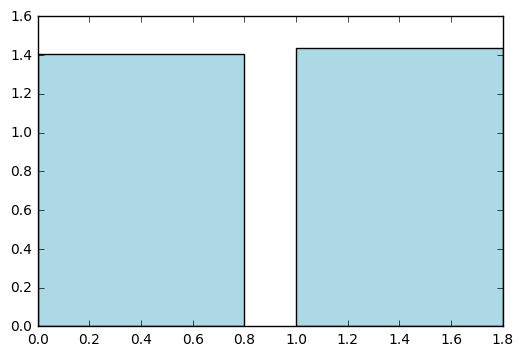

In [62]:
#Intercept, W에 적용하고, 타켓 변수의 평균값을 효과적으로 설명하는 상수 용어
#정규화 과정을 마친 이후에는 사용할 필요가 없으나, 어떤 경우라도 한번씩은 적용해주어야 함

params=[True, False]
metrics=[evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param) for param in params]
print(params)
print(metrics)
bar(params, metrics, color='lightblue') #막대형 그래프 생성

In [65]:
# DecisionTree에 대해 모델 매개변수 값에 따라 변화를 관찰한다.
def evaluate_dt(train, test, maxDepth, maxBins):
    model=DecisionTree.trainRegressor(train, {}, impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds=model.predict(test.map(lambda t:t.features))
    actual=test.map(lambda t:t.label)
    tp=actual.zip(preds)
    rmsle=np.sqrt(tp.map(lambda t:squared_log_error(t[0], t[1])).mean())
    return rmsle

[1, 2, 3, 4, 5, 10, 20, 30]
[1.474645341612014, 1.4439225955911539, 1.4040895562440876, 1.3693371526134552, 1.3160812287396264, 1.0900398288797661, 0.61902253166115839, 0.55249978267321731]


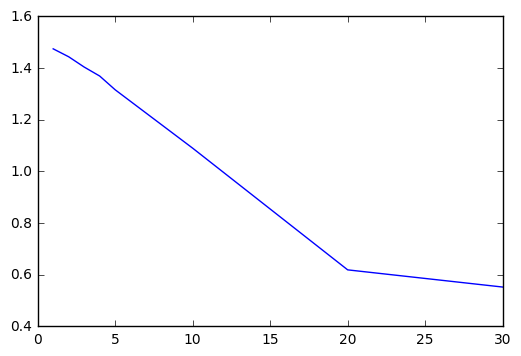

In [68]:
#트리 깊이에 따라 변화 여부를 관찰한다.
#시간이 꽤나.. 걸린다
#30 이하로 테스트 해야함 그 이상일시, 에러가 발생한다.
params=[1,2,3,4,5,10,20,30]
metrics=[evaluate_dt(train_data, test_data, param, 32) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf() # 꼭 안써도 됨(figure 객체를 사용하지 않으므로)

[2, 4, 6, 8, 16, 32, 64, 100, 200]
[1.2602146459894086, 0.80428522066456365, 0.83708370522013154, 0.73956106746462436, 0.62766656648619723, 0.63620635524276747, 0.63620635524276747, 0.63620635524276747, 0.63620635524276747]


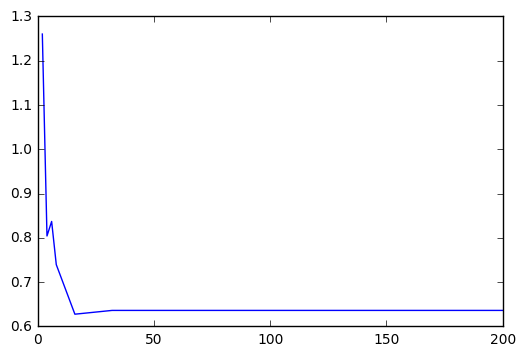

In [71]:
#최대 저장소(maxBins) 변환
params=[2,4,6,8,16,32,64,100, 200]
metrics=[evaluate_dt(train_data_dt, test_data_dt, 5, param) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
# 특성 수치에 이르면 값이 변하지 않는 것을 알 수 있다.